The goal here is to modify the notebook that calculates cluster statistics on both <b> TRMM </b> and <b> CMIP6 </b> model output. 

The cluster code will save information about the cluster center-of-mass

Import modules


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import matplotlib
from matplotlib.ticker import MaxNLocator,FormatStrFormatter
import pickle
from glob import glob
import sys  
import matplotlib.gridspec as gridspec
from scipy.stats import linregress
from dateutil.relativedelta import relativedelta
import itertools
import pickle
from cartopy.util import add_cyclic_point


from scipy.ndimage import label,find_objects
import scipy.ndimage as ndimage
from matplotlib.colors import LinearSegmentedColormap

import datetime as dt

import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import pandas as pd
from scipy.stats import norm
import os 




%matplotlib inline

### Try using dask 

In [2]:
from dask.distributed import Client
client = Client(n_workers=4, threads_per_worker=1)
client

/home/fiaz/anaconda3/envs/aos112/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44336 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:39604 Dashboard: http://127.0.0.1:44336/status,Cluster Workers: 4 Cores: 4 Memory: 387.99 GB


CMIP6 stands for Coupled Model Intercomparison Project 6, : <a href="https://www.wcrp-climate.org/wgcm-cmip/wgcm-cmip6">https://www.wcrp-climate.org/wgcm-cmip/wgcm-cmip6</a>.
The algorithm in this notebook is roughly as follows:
<ol>
    <li> Create a list of CMIP6 files to read with specified start and end dates. Each file contains one month of data. </li>
    <li> Visualize the precipitation field, and the corresponding clusters for a specific time step. You can play around with this to develop a physical intuition for clusters </li>
    <li> Create clusters and construct probability density functions (pdfs) for cluster size and cluster power. The data can be saved to file to avoid re-running time consuming computation. </li>
    <li> Plot the pdfs for different time periods. You can play around to see how the pdfs vary with time length and period. Also include information about the cutoff in the plots. </li>
</ol>


<b>EDIT:</b> a few changes have been made to the previous version of this notebook:
<ol>
    <li> We now use the xarray package to read and slice input files</li>
    <li> We can now set the starting and ending dates for extraction, so you can use the same time period across models </li>
    <li> We now read both historical and SSP runs in the same notebook </li>
</ol>

<b> <font color=blue>EDITS (08/09/20)</font>:</b>
<ol>
    <li> We can now skip the visualization of precip. maps. Clicking on a link now directly takes you the cluster pdf computation part of the code.</li>
    <li> We now save the grid size information in the .out files, so they don't have to be read in separately when comparing historical to SSP. </li>
</ol>

<b> <font color=blue>EDITS (10/15/20)</font>:</b>
<ol>
    <li> We have now implemented errorbars in the plotting routine.</li>
    <li> We have changed the plotting workflow; now there is a separate plotting function which takes takes preset plotting parameters</li>
    <li> The plotting function can also do log-linear plots, and compute $a_L$ and $c_L$ </li>
</ol>

### 1. Create a list of CMIP6 files to read with specified start and end dates. <br> Each file contains one month of data.


### First set the type of forcing ('HIST' or 'SSP')

In [19]:
forcing='HIST'
# forcing='SSP'
# forcing='obs'

## small snippet to extract model names from the scratch directory ##
if forcing=='HIST':
    diri='/scratch/neelin/CMIP6/'
    diri='/neelin2020/CMIP6-HISTORICAL/'
elif forcing=='SSP':
#     diri='/scratch/neelin/CMIP6-SSP585/'
    diri='/neelin2020/CMIP6-SSP585/'


pr_dir='HIST_r1i1p1f2/pr'
# pr_dir='pr'
pr_ext='3hr'
# pr_ext=''
# pr_ext='E1hr'
# pr_ext='6hrPlev' ## for NorESM2-MM


model_list=[]
model_dir=[]

if forcing!='obs':
    list_temp=(glob(diri+'*'))

    for name in list_temp:
        temp_name=name.split('/')[-1]
        model_list.append(temp_name)
        model_dir.append(diri+temp_name+'/'+pr_dir+'/pr_'+pr_ext+'*')

    model_list=model_list[1:] ### neglect the first name, since it is not really a model
    model_dir=model_dir[1:] ### neglect the first name, since it is not really a model
    print(model_list)
    model_index=model_list.index('CNRM-CM6-1') ## find index of any model you want    

    
elif forcing=='obs':
    model_dir.append('/scratch/neelin/TRMM_3B42/*')
    model_index=0

['@FGOALS-f3-L', '@GISS-E2-1-G', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CMIP6-yxli.tar', 'auto_folder.ncl', 'wget_multi.ncl', 'CESM2', 'CNRM-CM6-1-HR', 'CNRM-CM6-1', 'FGOALS-g3', 'GFDL-CM4', 'IITM-ESM', 'KACE-1-0-G', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'MPI-ESM1-2-HR', 'CanESM5', 'SAM0-UNICON', '@IPSL-CM6A-LR', 'IPSL-CM6A-LR', 'GISS-E2-1-G', 'BCC-CSM2-MR_HIST_tas.sh', 'AWI-ESM-1-1-LR', 'CMCC-CM2-SR5', 'CMCC-CM2-ESM2', 'CNRM-ESM2-1', 'HadGEM3-GC31-MM', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR-INCA', 'IPSL-CM5A2-INCA', 'TaiESM1', 'UKESM1-0-LL']


### check the list of files in the model directory to see what the ```pr_ext``` variable should be ##

In [24]:
model_dir[model_index]

'/neelin2020/CMIP6-HISTORICAL/CNRM-CM6-1/HIST_r1i1p1f2/pr/pr_3hr*'

In [25]:
os.listdir('/neelin2020/CMIP6-HISTORICAL/CNRM-CM6-1/HIST_r1i1p1f2/pr/')

['pr_3hr_CNRM-CM6-1_historical_r1i1p1f2_gr_200001010130-200912312230.nc',
 'pr_3hr_CNRM-CM6-1_historical_r1i1p1f2_gr_201001010130-201412312230.nc']

### Read files and extract subsets in time and latitude

In [26]:
model_files=glob(model_dir[model_index])


In [27]:
model_files

['/neelin2020/CMIP6-HISTORICAL/CNRM-CM6-1/HIST_r1i1p1f2/pr/pr_3hr_CNRM-CM6-1_historical_r1i1p1f2_gr_200001010130-200912312230.nc',
 '/neelin2020/CMIP6-HISTORICAL/CNRM-CM6-1/HIST_r1i1p1f2/pr/pr_3hr_CNRM-CM6-1_historical_r1i1p1f2_gr_201001010130-201412312230.nc']

In [28]:
model_files=glob(model_dir[model_index])
### READ model file ###
PR_VAR='pr'
PRECIP_FACTOR=36e2 ## Factor to convert precip. units to mm/hr


if forcing=='obs':
    PR_VAR='precip_trmm'
    PRECIP_FACTOR=1.0
    
### Read all model files ###
pr_ds=xr.open_mfdataset(model_files)

### fix datetime format ##
def fix_datetime(ds):

    try:
        datetimeindex = ds.indexes['time'].to_datetimeindex()
        ds['time'] = datetimeindex
    except:
        pass

fix_datetime(pr_ds)

if forcing!='obs':
    ### changing the longitude values from -180 to 180 to avoid some plotting errors 
    pr_ds.coords['lon'] = (pr_ds.coords['lon'] + 180) % 360  - 180
    pr_ds = pr_ds.sortby(pr_ds.lon)

elif forcing=='obs':
    pr_ds=pr_ds.rename({'latitude':'lat','longitude':'lon'})
    pr_ds.coords['lon'] = (pr_ds.coords['lon'] + 180) % 360  - 180
    pr_ds = pr_ds.sortby(pr_ds.lon)


### get the dateline longitude closes to 180 
dateline_indx=np.argmin(180-abs(pr_ds.lon.values))
datetline=pr_ds.lon.isel(lon=dateline_indx).values    

/home/fiaz/anaconda3/envs/aos112/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


### Fixing the datetime: KACE ##

In [29]:
# yr,mo,day,hr=pr_ds.time[0].dt.year,pr_ds.time[0].dt.month,pr_ds.time[0].dt.day,pr_ds.time[0].dt.hour
# strt_date=dt.datetime(yr,mo,day,hr)
# pr_ds['time']=pd.date_range(strt_date,freq='3H',periods=pr_ds.time.size)

### Examine the data time range use it set time bounds for extraction##
The cell below gives starting and ending year and month

In [30]:
print(pr_ds.time[0].dt.year.values,pr_ds.time[0].dt.month.values)
print(pr_ds.time[-1].dt.year.values,pr_ds.time[-1].dt.month.values)

2000 1
2014 12


In [32]:
## Specify start and end dates to extract from
# strt_date=dt.datetime(2091,1,1)
# end_date=dt.datetime(2100,12,31)

strt_date=dt.datetime(2005,1,1)
end_date=dt.datetime(2014,12,31)

# strt_date=dt.datetime(1990,1,1)
# end_date=dt.datetime(1999,12,31)


time_slice=slice(strt_date,end_date)
## Specify latitudinal bounds to extract
lat_slice=slice(-30,30)
pr_ds=pr_ds.sel(time=time_slice,lat=lat_slice) ## only extract specified timeslice

lon=pr_ds.lon
lat=pr_ds.lat

dates=pr_ds.time.dt.strftime('%Y-%M-%d %H')

### Declare useful constants related to grid sizes ###

In [33]:
Rearth=6.37e6  ## Earth's equatorial radius in meters

## get the grid sizes dx and dy in meters ###
nx =lon.size # no. of grid points
ny =lat.size  
dx=2.*np.pi*Rearth*(np.cos(np.pi*lat.values/180))/nx           #whole globe, periodic in x, dx in meters
dphi=np.gradient(lat.values)*np.pi/180  ## dphi in radians
dy=dphi*Rearth ## dy in meters

## for simplicity, we assume a single dx and dy for the domain. 
## Even though we should recognize that dx and dy vary with latitude.
precip_cluster_power_scale=2.5*dx.mean()*dy[0]*1e-6/3.6 ## cluster power in GW  ## Convert integrated precip. into power
pixels_to_area=dx.mean()*dy[0]*1e-6 ### factor convert the number of pixels to area in km^2

Read precip

In [34]:
prc=pr_ds[PR_VAR]*PRECIP_FACTOR

<b> Note: if the goal is to only look at the cluster pdfs, the next few cells can be skipped</b>. Click [here](#cell_cluster_pdfs) to go to the cluster pdf computation

### Read precip. values, and mask values below threshold ###

In [35]:
prc_min_thresh=0.25 ## in mm/hr
prc_masked=prc.where(prc>=prc_min_thresh)

### 2. Visualize the precipitation field, and the corresponding clusters for a specific time step.

In [36]:
### Create colorbar for precipitation ###

nws_precip_colors = [
#     "#04e9e7",  # 0.01 - 0.10 inches
#     "#019ff4",  # 0.10 - 0.25 inches
    "#0300f4",  # 0.25 - 0.50 inches
    "#02fd02",  # 0.50 - 0.75 inches
    "#01c501",  # 0.75 - 1.00 inches
    "#008e00",  # 1.00 - 1.50 inches
    "#fdf802",  # 1.50 - 2.00 inches
    "#e5bc00",  # 2.00 - 2.50 inches
    "#fd9500",  # 2.50 - 3.00 inches
    "#fd0000",  # 3.00 - 4.00 inches
    "#d40000",  # 4.00 - 5.00 inches
    "#bc0000",  # 5.00 - 6.00 inches
#     "#f800fd",  # 6.00 - 8.00 inches
#     "#9854c6",  # 8.00 - 10.00 inches
#     "#fdfdfd"   # 10.00+
]
precip_colormap = matplotlib.colors.ListedColormap(nws_precip_colors)

levels=np.arange(0.0,5.5,.5)
levels_mean=np.arange(0.0,5.5,.5)*1e-1
norm_inst = matplotlib.colors.BoundaryNorm(levels, precip_colormap.N)
norm_mean = matplotlib.colors.BoundaryNorm(levels_mean, precip_colormap.N) 

Pick a specific time step. Visualize the precipitation map, and the clusters that can be formed out this map. Change time step to get a feel for how the clusters are produced.

In [37]:
### Select time step here ##
### note that you have to specify hours too as T01-T23 or you get all the values in a given day ##
### just type pr_ds.time in a new cell to see the time format ###
# select_date='2099-04-01T21'
# select_date='2013-04-01T19'
select_date='1995-01-01T19'


prc_inst=np.squeeze(prc_masked.sel(time=select_date,method='nearest').values)

First declare some values useful constants 

In [265]:
#pr_ds=pr_ds.rename({"precip_trmm":"pr"}) #Uncomment for TRMM 3B42

In [266]:
# prc_input=np.ma.masked_invalid(prc_inst)
prc_input=np.squeeze(pr_ds.sel(time=select_date).pr.values*PRECIP_FACTOR)
prc_input[prc_input<prc_min_thresh]=0.0

In [267]:
### Use pixel contiguity to identify clusters ##
labeled_prc, num_features = label(prc_input)
levels_labels=np.arange(0,num_features,1)
labels_masked=np.ma.masked_where(labeled_prc==0,labeled_prc)
cluster_power_masked=np.zeros_like(labels_masked)

### store center-of-mass coords as lat, lon
com_coords=np.zeros((2,levels_labels.size))
pcp_power=np.zeros((levels_labels.size))

### get the center of mass co-ordinates in (x,y) for each precip. cluster ###

pal=plt.get_cmap('YlGnBu')

label_objs=find_objects(labels_masked)

def compute_com(sl,label,lat,lon,pcp_slice,label_slice):
    '''
    Simple function to compute the center of mass for each cluster
    '''
    mesh_lon,mesh_lat=np.meshgrid(lon[sl[1]].values,lat[sl[0]].values)
    
    if not np.all((mesh_lon.flatten())<0) and not np.all((mesh_lon.flatten())>=0):
        print(mesh_lon)
        
    com_lat=np.average(mesh_lat[np.where(label_slice==label)],
                     weights=pcp_slice[label_slice==label])
    com_lon=np.average(mesh_lon[np.where(label_slice==label)],
                     weights=pcp_slice[label_slice==label])
        
    return com_lat,com_lon


for j in np.arange(len(label_objs)):

    sl=label_objs[j]
    pcp_slice=prc_input[sl]
    label_slice=labels_masked[sl]
    cluster_power_masked[sl][pcp_slice>0]=pcp_slice.sum()*precip_cluster_power_scale
    if j>0:
        com_coords[0,j],com_coords[1,j]=compute_com(sl,j+1,lat,lon,pcp_slice,label_slice)
    elif j==0:
        com_coords[:,j]=np.nan
    pcp_power[j]=pcp_slice.sum()*precip_cluster_power_scale
    
    
levels_pow=np.arange(2.0,7.5,.5)
norm_pow = matplotlib.colors.BoundaryNorm(levels_pow, precip_colormap.N)

In [268]:
com_coords_large=com_coords[:,np.where(pcp_power>1e5)[0]]

### Plot mean precipitation for check values

In [ ]:
### Time mean here is the mean over masked values ###
prc_mean=prc.where(prc>=0).mean(dim='time').values

In [ ]:
### Removing the central_longitude=180 will switch the plot center ##
fig,axx = plt.subplots(1,1,figsize=(12, 3),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}) 
ax=axx
ax.coastlines()
ax.set_extent([lon.values[0],lon.values[-1],lat.values[0],lat.values[-1]], crs=ccrs.PlateCarree())
CT=ax.imshow(prc_mean, 
             cmap=precip_colormap,
             interpolation='none',norm=norm_mean, 
             extent=[lon.values[0],lon.values[-1],lat.values[0],lat.values[-1]],
             origin='lower',
             transform=ccrs.PlateCarree())


#get size and extent of axes:
ax.set_aspect('auto')

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(CT, cax=pos_cax,label='mm/hr',format='%.3f')
font = matplotlib.font_manager.FontProperties(family='Arial',  size=14)
pos_cax.yaxis.label.set_font_properties(font)
pos_cax.tick_params(which='both',labelsize=12.)

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height

if forcing in ['SSP','HIST']:
    ax.set_title('Time mean %s precipitation from %s-%s'%(model_list[model_index],time_slice.start.strftime("%Y%m"),time_slice.stop.strftime("%Y%m")),fontsize=15)
else:
    ax.set_title('Time mean precipitation from TRMM 3B42',fontsize=15)


    
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlines = True
gl.ylocator = mticker.FixedLocator(np.arange(-90,90,30))
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,45))
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
plt.tight_layout()

if forcing=='SSP':
    fname='Time_mean_precip_SSP585_%s'%(model_list[model_index])+'_'+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+'.pdf'
elif forcing=='HIST':
    fname='Time_mean_precip_%s'%(model_list[model_index])+'_'+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+'.pdf'
## stores in a local directory called plots ##
# plt.savefig('./plots/'+fname,format='pdf',dpi=150,bbox_inches='tight')

### Plot selected timestep ###

/home/fiaz/anaconda3/envs/aos112/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/fiaz/anaconda3/envs/aos112/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-197-82febd7e4dc2>:55: RuntimeWarning: divide by zero encountered in log10
  CT=ax.imshow(np.log10(cluster_power_masked),cmap=precip_colormap,interpolation='none',aspect='auto',
<ipython-input-197-82febd7e4dc2>:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


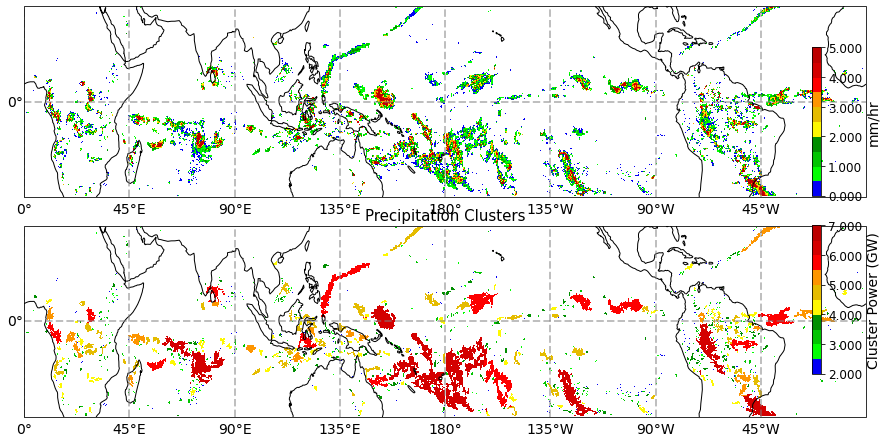

In [197]:
fig,axx = plt.subplots(2,1,figsize=(12, 6),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                      constrained_layout=False)

ax=axx[0]
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180),figsize=(12,6))
ax.coastlines()
ax.set_extent([lon.values[0],lon.values[-1],lat.values[0],lat.values[-1]], crs=ccrs.PlateCarree())
CT=ax.imshow(prc_inst, 
             cmap=precip_colormap,
             interpolation='none',norm=norm_inst, 
             extent=[lon.values[0],lon.values[-1],lat.values[0],lat.values[-1]],
             origin='lower', 
             transform=ccrs.PlateCarree())
ax.set_aspect('auto')

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(CT, cax=pos_cax,label='mm/hr',format='%.3f')
font = matplotlib.font_manager.FontProperties(family='Arial',  size=14)
pos_cax.yaxis.label.set_font_properties(font)
pos_cax.tick_params(which='both',labelsize=12.)

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height

if forcing=='SSP':
    ax.set_title('%s SSP585 precipitation at %s'%(model_list[model_index],dates.sel(time=select_date).values),fontsize=15)
elif forcing=='HIST':
    ax.set_title('%s precipitation at %s'%(model_list[model_index],dates.sel(time=select_date).values),fontsize=15)


gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlines = True
gl.ylocator = mticker.FixedLocator(np.arange(-90,90,30))
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,45))
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

ax=axx[1]
ax.coastlines()
ax.set_extent([lon.values[0],lon.values[-1],lat.values[0],lat.values[-1]], crs=ccrs.PlateCarree())
CT=ax.imshow(np.log10(cluster_power_masked),cmap=precip_colormap,interpolation='none',aspect='auto',
             origin='lower',norm=norm_pow,
             extent=[lon.values[0],lon.values[-1],lat.values[0],lat.values[-1]],
             transform=ccrs.PlateCarree())

ax.scatter(com_coords[0,0],com_coords[0,1], s=200, marker='*',
           c='lightgreen',transform=ccrs.PlateCarree())

ax.set_aspect('auto')

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(CT, cax=pos_cax,label='Cluster Power (GW)',format='%.3f')
font = matplotlib.font_manager.FontProperties(family='Arial',  size=14)
pos_cax.yaxis.label.set_font_properties(font)
pos_cax.tick_params(which='both',labelsize=12.)

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height

ax.set_title('Precipitation Clusters',fontsize=15)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlines = True
gl.ylocator = mticker.FixedLocator(np.arange(-90,90,30))
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,45))
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
plt.tight_layout()

if forcing=='SSP':
    fname='Instantaneous_precip_SSP585_%s_%s'%(model_list[model_index],select_date)+'.pdf'
elif forcing=='HIST':
    fname='Instantaneous_precip_%s_%s'%(model_list[model_index],select_date)+'.pdf'    
## stores in a local directory called plots ##
# plt.savefig('./plots/'+fname,format='pdf',dpi=150,bbox_inches='tight')

In [269]:
#Make marker size proportional to cluster power
marker_size=2**np.log10(pcp_power)
marker_size.min()

12.886459643174637

<ipython-input-270-3e807835df09>:7: RuntimeWarning: divide by zero encountered in log10
  CT=ax.imshow(np.log10(cluster_power_masked),cmap=precip_colormap,interpolation='none',aspect='auto',
/home/fiaz/anaconda3/envs/aos112/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/fiaz/anaconda3/envs/aos112/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-270-3e807835df09>:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


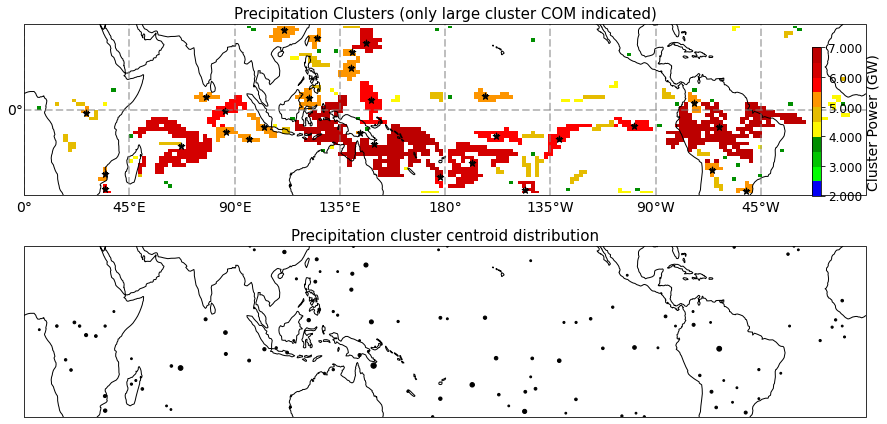

In [270]:
fig,axx = plt.subplots(2,1,figsize=(12, 6),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                      constrained_layout=False)

ax=axx[0]
ax.coastlines()
ax.set_extent([lon.values[0],lon.values[-1],lat.values[0],lat.values[-1]], crs=ccrs.PlateCarree())
CT=ax.imshow(np.log10(cluster_power_masked),cmap=precip_colormap,interpolation='none',aspect='auto',
             origin='lower',norm=norm_pow,
             extent=[lon.values[0],lon.values[-1],lat.values[0],lat.values[-1]],
             transform=ccrs.PlateCarree())

ax.scatter(com_coords_large[1,:],com_coords_large[0,:],s=50,marker='*',color='black',
           transform=ccrs.PlateCarree()) 


ax.set_aspect('auto')

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(CT, cax=pos_cax,label='Cluster Power (GW)',format='%.3f')
font = matplotlib.font_manager.FontProperties(family='Arial',  size=14)
pos_cax.yaxis.label.set_font_properties(font)
pos_cax.tick_params(which='both',labelsize=12.)

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height

ax.set_title('Precipitation Clusters (only large cluster COM indicated)',fontsize=15)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlines = True
gl.ylocator = mticker.FixedLocator(np.arange(-90,90,30))
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,45))
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}


ax=axx[1]
ax.coastlines()
ax.set_extent([lon.values[0],lon.values[-1],lat.values[0],lat.values[-1]], 
              crs=ccrs.PlateCarree())

ax.scatter(com_coords[1,:],com_coords[0,:],s=marker_size,marker='.',color='black',
           transform=ccrs.PlateCarree()) 
ax.set_aspect('auto')
ax.set_title('Precipitation cluster centroid distribution',fontsize=15)


plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)


<a id='cell_cluster_pdfs'></a>  

### Create cluster pdfs ###

Create bins to hold the cluster size and power pdfs

In [38]:
#### CLUSTER SIZE and POWER PDF bins ###
sizes=2**np.arange(0,18.25,.25)
sizes=np.unique(np.int_(sizes))-0.5

sz=(sizes[:-1]+sizes[1:])*0.5
sz_diff=np.diff(sizes)

pcp_clus_pow_bins=sizes*precip_cluster_power_scale*0.5
pcp_clust_sz=(pcp_clus_pow_bins[:-1]+pcp_clus_pow_bins[1:])*0.5
pcp_clust_sz_diff=np.diff(pcp_clus_pow_bins)

Create a list of precip. thresholds

In [39]:
pthresh_list=[.25, .5, .75, 1.0]  ## list of precip. thresholds

Function to perform cluster analysis. Takes file name as input and yields outputs:
    <ol>
    <li> Counts of precip. cluster power</li>
    <li> Counts of precip. cluster size </li>
    <li> List of cluster power </li>
    <li> List of cluster size </li>
    </ol>

The counts will be use to create historgrams. The lists of cluster power and size will allow us to estimate measures like the moment ratio (which is a proxy for the exponential cutoff).


Unlike the TRMM precipitation, where we had one file per day, the CMIP6 precipitation is in one giant variable. So we will modify our strategy related to parallel computing. 

In [40]:
def compute_com(sl,label,lat,lon,pcp_slice,label_slice):
    '''
    Simple function to compute the center of mass for each cluster
    '''
    
    mesh_lon,mesh_lat=np.meshgrid(lon[sl[1]].values,lat[sl[0]].values)

    ### If cluster spans the dateline ##
    if not np.all((mesh_lon.flatten())<0) and not np.all((mesh_lon.flatten())>=0) and abs(datetline) in abs(mesh_lon):
        
        ## convert negative values to be continuous with 180 ###
        
        mesh_lon[mesh_lon<0]+=360
            
        com_lat=np.average(mesh_lat[np.where(label_slice==label)],
                     weights=pcp_slice[label_slice==label])
        com_lon=np.average(mesh_lon[np.where(label_slice==label)],
                         weights=pcp_slice[label_slice==label])
        
        ## re-convert com if > 180  ###
        
        com_lon=com_lon-360 if com_lon>180 else com_lon 
        

    else:
    
        com_lat=np.average(mesh_lat[np.where(label_slice==label)],
                         weights=pcp_slice[label_slice==label])
        com_lon=np.average(mesh_lon[np.where(label_slice==label)],
                         weights=pcp_slice[label_slice==label])
    
    return com_lat,com_lon


def perform_cluster_analysis_cmip6(prc):
        
    hist_pcp_sizes={}   
    hist_pcp_clust_pow={}
    pcp_sizes={}
    pcp_power={}
    com_coords={}
    
    for k in pthresh_list:
                
        arrp=np.copy(prc)
        arrp[prc>k]=1
        arrp[prc<=k]=0
        hist_pcp_sizes[k]=np.zeros_like(sz)    
        hist_pcp_clust_pow[k]=np.zeros_like(pcp_clust_sz)
        
        pcp_sizes[k]=np.zeros((1))
        pcp_power[k]=np.zeros((1))
        com_coords[k]=np.zeros((2,1))


        
        for ti in np.arange(prc.shape[0]):
            
            ### Cluster precipitation ###
        
            labeled_array_pcp, num_features_pcp = label(arrp[ti,:])
            ind=np.where(labeled_array_pcp[:,0]>0)[0]            
                
            ## Condition to take care of doubly periodic clusters ##

            # Assuming lat x lon array
            # Are there pixels along the longitude boundary whose label values are both > 0? 
            if any(np.logical_and(labeled_array_pcp[:,-1][ind]>0,labeled_array_pcp[:,0][ind]>0)):

                # If yes, then get their local addresses in the column        
                indy=np.where(np.logical_and(labeled_array_pcp[:,-1][ind]>0,labeled_array_pcp[:,0][ind]>0))
                # Loop through each address        
                for j in indy[0]:
                    # Get the destination label: of the last column
                    dest_label=labeled_array_pcp[:,-1][ind][j]
                    # Get the target label: of the first column
                    target_label=labeled_array_pcp[:,0][ind][j]
                    # Make all pixels with destination labels=target labels
                    labeled_array_pcp[labeled_array_pcp==dest_label]=target_label

                ## Update number of features
                num_features_pcp=np.unique(labeled_array_pcp[labeled_array_pcp>0]).size
                                        
            if num_features_pcp==0:
                mx,mn=1,0
            else:
                mx,mn=labeled_array_pcp.max(),1
                        
            ## Bin by cluster size ##

            hist_label=(ndimage.histogram(labeled_array_pcp,mn,mx,mx,labels=labeled_array_pcp))
            hist_pcp_sizes[k]+=np.histogram(hist_label,bins=sizes)[0]
            
            
###           snippet to determine timestep with largest clusters ###
#             if smax==0:
#                 smax=hist_label[hist_label>0].max()
#                 tmax=0
            
#             elif (hist_label[hist_label>0].max()>smax):
#                 smax=hist_label[hist_label>0].max()
#                 tmax=ti
            
            pcp_sizes[k]=np.append(pcp_sizes[k],hist_label[hist_label>0])
            label_objs=find_objects(labeled_array_pcp)
            pcp_cluster_pow=np.zeros(len(label_objs))
            pcp_cluster_sz=np.zeros(len(label_objs))
                        
            ### Save center-of-mass co-ordinates ##
            com_coords_clusters=np.zeros((2,len(label_objs)))


            ## Compute and bin by cluster power
            ctr=0             
            for j in np.arange(len(label_objs)):

                sl=label_objs[j]
                arrp_slice=arrp[ti,:][sl]
                pcp_slice=prc[ti,:][sl]
                label_slice=labeled_array_pcp[sl]
                indj=np.where(label_slice==j+1)
                pcp_cluster_pow[j]=pcp_slice[indj].sum()*precip_cluster_power_scale
                pcp_cluster_sz[j]=pcp_slice[indj].size
                if sl:
                    com_coords_clusters[0,j],com_coords_clusters[1,j]=compute_com(sl,j+1,lat,lon,pcp_slice,label_slice)
                else:
                    com_coords_clusters[0,j],com_coords_clusters[1,j]=np.nan,np.nan
                


            if (pcp_cluster_pow[pcp_cluster_pow>0].shape!=hist_label[hist_label>0].shape):
                print ('power, size:', pcp_cluster_pow[pcp_cluster_pow>0].shape,pcp_cluster_sz[pcp_cluster_sz>0].shape, 
                       hist_label[hist_label>0].shape)
                exit()
            pcp_power[k]=np.append(pcp_power[k],pcp_cluster_pow[pcp_cluster_pow>0])  
            com_coords[k]=np.append(com_coords[k],com_coords_clusters[:,np.where(pcp_cluster_pow>0)[0]],axis=1)
            hist_pcp_clust_pow[k]+=np.histogram(pcp_cluster_pow,bins=pcp_clus_pow_bins)[0]
            pcp_power[k]=pcp_power[k][1:]  ## neglect the first value, since it is zero
            pcp_sizes[k]=pcp_sizes[k][1:]
            com_coords[k]=com_coords[k][:,1:]
            
    return hist_pcp_clust_pow, hist_pcp_sizes, pcp_power, pcp_sizes, com_coords 




We have a large number of files to work with. So to speed up the code, we will recruit multiple processors to work through the data. The jupyter machine has 160 processors, but we will recruit a fraction of this number to avoid clogging up the machine. To see how many processors are currently available, you can open a terminal and type `htop`.

<p>
We first define the number of desired processors that will work in parallel. Each processor will work with one subset of the precip. array at a time, which is the input to `perform_cluster_analysis`. The results from different processors are then pooled at the end. <br> <b> Note:</b> this step can be time consuming depending on number of files being processed.
</p>

In [41]:
prc_values=prc.values ### load the precip. values into memory; this step can be slightly time-consuming depending on array size

<a id='cell_multiprocess'></a>  

In [42]:
# %%capture output 
from multiprocessing import Pool  ### module for parallel programming
import time as time_module ## module to time this cell
nproc=50

### first split the array into a list of sub-arrays
prc_subarray=np.array_split(prc_values,nproc,axis=0)  ## split precip. array along time axis ###
start_time=time_module.time()
pool = Pool(processes=nproc)
pooled_list = pool.map(perform_cluster_analysis_cmip6, prc_subarray) ### a list containing all the pooled results
print('Took %.2f minutes'%((time_module.time()-start_time)/60))

Took 2.24 minutes


Organize the results from the cluster analysis, and save to file (optional).

In [43]:
### create dictionaries to collect and store output ###
### each dictionary has a key associated with the precip. threshold ###
hist_pcp_sizes={}   
hist_pcp_clust_pow={}
pcp_sizes={}
pcp_power={}
com_coords={}

## Create empty lists to store the cluster counts (hist) and the collection of actual cluster metrics
for k in pthresh_list:
    hist_pcp_sizes[k]=[]   
    hist_pcp_clust_pow[k]=[]  
    pcp_sizes[k]=[]  
    pcp_power[k]=[]  
    com_coords[k]=[]  

### Stack the pooled output from above into these lists
for i in range(len(pooled_list)):
    cluster_list=(pooled_list[i])
    for k in pthresh_list:
        hist_pcp_clust_pow[k].append(cluster_list[0][k])
        hist_pcp_sizes[k].append(cluster_list[1][k])
        pcp_power[k].append(cluster_list[2][k])
        pcp_sizes[k].append(cluster_list[3][k])
        com_coords[k].append(cluster_list[4][k])


### Convert the lists into arrays ###
for k in pthresh_list:
    hist_pcp_clust_pow[k]=np.asarray(hist_pcp_clust_pow[k]).sum(0)  ### sum the counts across all files
    hist_pcp_sizes[k]=np.asarray(hist_pcp_sizes[k]).sum(0)  ### sum the counts across all files
    pcp_power[k]=np.hstack(pcp_power[k]) ## stack all the power measurements
    pcp_sizes[k]=np.hstack(pcp_sizes[k]) ## stack all the size measurements
    com_coords[k]=np.hstack(com_coords[k]) ## stack the centroid measurements
    
###
SAVE=True
if SAVE:
    dir_save='./' ### change as per required destination, default is current working directory
    data={}
    data['hist_pcp_sizes']=hist_pcp_sizes
    data['hist_pcp_clust_pow']=hist_pcp_clust_pow
    data['pcp_sizes']=pcp_sizes
    data['pcp_power']=pcp_power
    data['sizes']=sizes
    data['precip_cluster_power_scale']=precip_cluster_power_scale
    data['pixels_to_area']=pixels_to_area
    data['cluster_centroid_coords']=com_coords
    if forcing=='SSP':
        save_file_name=dir_save+"clusters_output_SSP585_%s"%(model_list[model_index])+"_"+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+".out"
    elif forcing=='HIST':
        save_file_name=dir_save+"clusters_output_%s"%(model_list[model_index])+"_"+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+".out"
    elif forcing=='obs':
        save_file_name=dir_save+"clusters_output_%s"%('TRMM3B42')+"_"+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+".out"


        
    with open(save_file_name, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Plot cluster density on map 

In [44]:
model_list

['@FGOALS-f3-L',
 '@GISS-E2-1-G',
 'ACCESS-CM2',
 'ACCESS-ESM1-5',
 'BCC-CSM2-MR',
 'CMIP6-yxli.tar',
 'auto_folder.ncl',
 'wget_multi.ncl',
 'CESM2',
 'CNRM-CM6-1-HR',
 'CNRM-CM6-1',
 'FGOALS-g3',
 'GFDL-CM4',
 'IITM-ESM',
 'KACE-1-0-G',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM-1-2-HAM',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM2-LM',
 'NorESM2-MM',
 'MPI-ESM1-2-HR',
 'CanESM5',
 'SAM0-UNICON',
 '@IPSL-CM6A-LR',
 'IPSL-CM6A-LR',
 'GISS-E2-1-G',
 'BCC-CSM2-MR_HIST_tas.sh',
 'AWI-ESM-1-1-LR',
 'CMCC-CM2-SR5',
 'CMCC-CM2-ESM2',
 'CNRM-ESM2-1',
 'HadGEM3-GC31-MM',
 'HadGEM3-GC31-LL',
 'IPSL-CM6A-LR-INCA',
 'IPSL-CM5A2-INCA',
 'TaiESM1',
 'UKESM1-0-LL']

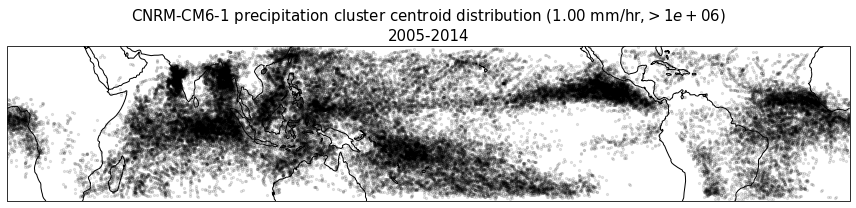

In [45]:
fig,axx = plt.subplots(1,1,figsize=(12, 3),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                      constrained_layout=False)
thresh=1.0
pow_thresh=1.0e6
## only plot the largest cluster centroids ###
com_coords_large_power=com_coords[thresh][:,np.where(pcp_power[thresh]>pow_thresh)[0]]

ax=axx
ax.coastlines()
ax.set_extent([lon.values[0],lon.values[-1],lat.values[0],lat.values[-1]], 
              crs=ccrs.PlateCarree())

ax.scatter(com_coords_large_power[1,:],com_coords_large_power[0,:],s=20,marker='.',color='black',
           transform=ccrs.PlateCarree(),alpha=0.1) 
ax.set_aspect('auto')
ax.set_title('%s precipitation cluster centroid distribution (%.2f mm/hr,$>%.0e$)\n%s-%s'%(model_list[model_index],thresh,pow_thresh,
                                                                                  strt_date.strftime("%Y"),end_date.strftime("%Y")),
             fontsize=15)


plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
if forcing=='SSP':
    fname='precip_cluster_density_SSP585_%s_%s_%s'%(model_list[model_index],strt_date.strftime("%Y"),end_date.strftime("%Y"))+'.pdf'
elif forcing=='HIST':
    fname='precip_cluster_density_HIST_%s_%s_%s'%(model_list[model_index],strt_date.strftime("%Y"),end_date.strftime("%Y"))+'.pdf'    
elif forcing=='obs':
    fname='TRMM3B42_precip_cluster_density_HIST_%s_%s'%(time_slice.start.strftime("%Y%m"),time_slice.stop.strftime("%Y%m"))+'.pdf'    

SAVE=True
if SAVE:
    plt.savefig('./plots/'+fname,format='pdf',dpi=150,bbox_inches='tight')

 <b> Note: </b> if the file has been saved above, you do not have to re-run the cell [with multiprocessing](#cell_multiprocess) or the cell that [organizes the data](#cell_oragnize_data) when you restart the kernel.


Now open the saved file and create the cluster pdfs

In [46]:
### If reading an already saved file
READ=True
if READ:
    dir_save='./' ### change as per required destination, default is current working directory

    if forcing=='SSP':
        read_file_name=dir_save+"clusters_output_SSP585_%s"%(model_list[model_index])+"_"+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+".out"
    elif forcing=='HIST':
        read_file_name=dir_save+"clusters_output_%s"%(model_list[model_index])+"_"+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+".out"
    elif forcing=='obs':
        read_file_name=dir_save+"clusters_output_%s"%('TRMM3B42')+"_"+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+".out"


    with open(read_file_name, 'rb') as handle:
        f = pickle.load(handle,encoding='bytes')
    hist_pcp_clust_pow=f['hist_pcp_clust_pow']
    hist_pcp_sizes=f['hist_pcp_sizes']
    pcp_sizes=f['pcp_sizes']
    pcp_power=f['pcp_power']
    sizes=data['sizes']
    precip_cluster_power_scale=data['precip_cluster_power_scale']
    pixels_to_area=data['pixels_to_area']


### 4. Plot the pdfs for different time periods. You can play around to see how the pdfs vary with time length and period. Also include information about the cutoff in the plots. 

In the plot below, we will present the following information:
<ol>
    <li> The cluster size and power pdfs on a log-log plot for the different rain thresholds. </li>
    <li> A straight line fit over the power law range (set by user), and the slope for one rain threshold case </li>
    <li> The moment ratio (second moment over first moment) for cluster size ($a_M$) and power ($c_M$). These quantiies can thought of as <b> proxies for where the exponential cutoff occur</b>.
</ol>

### Define the plotting functions ###

In [47]:
def wilson_score(ns,n,alpha):
    
        '''
        Here ns is the number of sucesses in a Bernoulli Trial, i.e., the number of samples in a given bin
        n is the number of Bernoulli trials, i.e., the number of samples overall
        alpha is the percent of confidence interval (e.g. 5%)
        '''        
        z=norm.ppf(alpha/2) ## get the probit of the confidence interval
#         err_upper=(ns/n)+z*np.sqrt(ns*(n-ns))/(n*np.sqrt(n))
#         err_lower=(ns/n-z)*np.sqrt(ns*(n-ns))/(n*np.sqrt(n))
    
        err_upper=(ns+0.5*z**2)/(n+z**2)+z/(n+z**2)*np.sqrt(ns*(n-ns)/n+z**2/4)
        err_lower=(ns+0.5*z**2)/(n+z**2)-z/(n+z**2)*np.sqrt(ns*(n-ns)/n+z**2/4)

        return err_lower, err_upper


def plot_cluster_stats(ax, pthresh_list, plot_params, hist, 
                       xvalue, diff, cluster_property):
    
    
    ### read plotting parameters ###
    istrt,iend=plot_params['istrt'],plot_params['iend']
    nthresh=plot_params['nthresh']
    colors=plot_params['colors']
    fit_limit,fit_operator=plot_params['fit_limit'],plot_params['fit_operator']
    xm,xL=plot_params['xm'],plot_params['xL']
    leg1_fontsize=plot_params['leg1_fontsize']
    TITLE=plot_params['TITLE']
    posx,posy=plot_params['posx'],plot_params['posy']
    leg_loc=plot_params['leg_loc']
    xlabel,ylabel=plot_params['xlabel'],plot_params['ylabel']
    xlim,ylim=plot_params['xlim'],plot_params['ylim']
    ytick_locator=plot_params['ytick_locator']
    ticks_fontsize=plot_params['ticks_fontsize']
    plot_type=plot_params['plot_type']
    xlabel_fontsize,ylabel_fontsize,title_fontsize=plot_params['xlabel_fontsize'],plot_params['ylabel_fontsize'],plot_params['title_fontsize']
    leg_fontsize,xlabel_fontsize,ylabel_fontsize,title_fontsize=plot_params['leg_fontsize'],plot_params['xlabel_fontsize'],plot_params['ylabel_fontsize'],plot_params['title_fontsize']

    errorbar=plot_params['errorbar']
    alpha=plot_params['confidence']

    ln1={}
    for j,k in enumerate(pthresh_list):
        

        if (k in pthresh_list):  ### use this if you want to plot a smaller subset of rain thresholds
            

            ### create pdfs out of cluster histogram of counts
            pdf=hist[k]/(diff*hist[k].sum())
            ### remove bins with less than nthresh counts ##
            pdf[hist[k]<nthresh]=np.nan
            
            if errorbar:
                error_lower,error_upper=wilson_score(hist[k],hist[k].sum(),alpha)
                error=np.array((error_lower/diff,error_upper/diff)) ## create error bars
                error[:,hist[k]<nthresh]=0
            
            ### plot the cluster pdf on specified plot type ##
            if plot_type=='loglog':
                if errorbar:
                    offsets= abs(pdf-error)## create error bars
                    ln1[j]=ax.errorbar(xvalue, pdf, yerr=offsets, fmt='*',c=colors[j],
                                capsize=2.25)
                else:
                    ln1[j],=ax.loglog(xvalue,pdf,marker='*',c=colors[j],markersize=5)


                    
            elif plot_type=='logylinearx':
                
                if errorbar:
                    offsets= abs(pdf-error)## create error bars
                    ln1[j]=ax.errorbar(xvalue, pdf, yerr=offsets, fmt='*',c=colors[j],
                                capsize=2.25)
                else:
                    ln1[j],=ax.semilogy(xvalue,pdf,marker='*',c=colors[j],markersize=5)



            else:
                ValueError('Enter valid values for plot_type: loglog or logylinearx')

        ### The straight line fit to the power law/exponential range ###
        ### select portions of the curve bounded by the power law/exponential range ###
        if plot_type=='loglog':
            arrx,arry=np.log10(xvalue),np.log10(pdf)
        elif plot_type=='logylinearx':
            arrx,arry=xvalue,np.log10(pdf)
    

        arrx_fin=arrx[np.logical_and(arrx>istrt[k],arrx<iend[k])]
        arry_fin=arry[np.logical_and(arrx>istrt[k],arrx<iend[k])]


        ### perform a linear regression over this selected portion ###
        try:
            ret=linregress(arrx_fin[np.isfinite(arry_fin)],
                           arry_fin[np.isfinite(arry_fin)])

            ### Use the slope and intercept from the linear regression to create the straight line ###
            if plot_type=='loglog':
                pdf_fit=((xvalue)**(ret[0]))*(10**(ret[1]))
                ## Remove portions of the straight line that extend too far beyond the cutoff
                pdf_fit[fit_operator(xvalue,fit_limit)]=np.nan 

            elif plot_type=='logylinearx':
                pdf_fit=10**(xvalue*ret[0]+ret[1])

                
        except:
            ret=[np.nan,np.nan]
            
        ### Now compute the moment ratio and print it in on plot ##
        if (k in pthresh_list):
            
            sm=np.mean(cluster_property[k]**2)/np.mean(cluster_property[k])
            if plot_type=='loglog':
                ax.text(posx[j],posy[j],'$%s$=%.2e'%(xm,sm),transform=ax.transAxes,
                    fontsize=leg1_fontsize,color=colors[j])

            if plot_type=='logylinearx':
                sL=-1./(ret[0]*np.log(10))
                ax.text(posx[j],posy[j],'%.2e (%.2e)'%(sL,sm),
                        transform=ax.transAxes,fontsize=leg1_fontsize,color=colors[j])

                ax.semilogy(xvalue,pdf_fit,linestyle='--',c=colors[j])


        if (j==len(pthresh_list)-1):

            ### Set plot title and axis labels
            ax.set_title(TITLE, fontsize=title_fontsize)
            ax.set_xlabel(xlabel,fontsize=xlabel_fontsize)
            ax.set_ylabel(ylabel,fontsize=ylabel_fontsize)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.yaxis.set_major_locator(plt.FixedLocator(ytick_locator))
            ax.tick_params(which='both', labelsize=ticks_fontsize)
            
            if plot_type=='loglog':
                ax.loglog(xvalue,pdf_fit,linestyle='--',c='black')
                ax.text(posx[j]-0.25,posy[j],'$\\tau$=%.1f'%(-ret[0]),
                    transform=ax.transAxes,fontsize=leg1_fontsize,color='black')
                
            elif plot_type=='logylinearx':
                ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

            leg=ax.legend((ln1[0],ln1[1],ln1[2],ln1[3]), \
            ( "%.2f"%(pthresh_list[0]), "%.2f"%(pthresh_list[1]), "%.2f"%(pthresh_list[2]), "%.2f"%(pthresh_list[3]),
            ),fontsize=leg_fontsize, loc=leg_loc,ncol=1 )
            ## make legend box color black ##
            frame=leg.get_frame()
            frame.set_edgecolor('black')



### Prepare the cluster size and power inputs to the plotting function ###



In [48]:
xvalue=sz*pixels_to_area
diff=np.diff(sizes)*pixels_to_area
cluster_sizes=dict.fromkeys(pthresh_list)

for key in pcp_sizes.keys():
    cluster_sizes[key]=pcp_sizes[key]*pixels_to_area
    
pcp_clus_pow_bins=sizes*precip_cluster_power_scale*0.5
pcp_clust_pow=(pcp_clus_pow_bins[:-1]+pcp_clus_pow_bins[1:])*0.5
pcp_clust_pow_diff=np.diff(pcp_clus_pow_bins)

### Set the parameters for the range over which we do power law/exponential fits ###

In [49]:
### here is where we specify the start and end values for the power law/exponential fits ###
### we have the option to enter four different ranges for the fits###
### the multiple ranges don't matter for the power law, but will matter for the exponential fits ###
istrt_sz=dict.fromkeys(pthresh_list)
iend_sz=dict.fromkeys(pthresh_list)

istrt_pow=dict.fromkeys(pthresh_list)
iend_pow=dict.fromkeys(pthresh_list)

### for the loglog plots, the power law range for size (10^3 to 10^5)
### set a ballpark range for the power law, so the straight line fit is over that range
for key in (istrt_sz.keys()):
    istrt_sz[key],iend_sz[key]=3.0,5.0
    istrt_pow[key],iend_pow[key]=3.0,5.5


#### Set all other plotting parameters  ###

In [50]:
plot_params={}

plot_params['plot_type']='loglog'

## Fitting parameters ###
plot_params['nthresh']=10      ### threshold counts for bin to be valid
plot_params['istrt']=istrt_sz  ### start of the fit regime
plot_params['iend']=iend_sz    ### end of the fit regime

### Limits and operator to decide the range over which the pdf is fit ##
plot_params['fit_limit']=5e6   ## if extrapolating beyond the fit regime specify limit
plot_params['fit_operator']=np.greater ## if extrapolating beyond the fit regime specify operator (greater or less)

### specify limits 
## x and yaxis limits for cluster size

plot_params['xlim']=[5e2,1e8]
plot_params['ylim']=[1e-13,1e-1]

### setting title here 
if forcing!='obs':
    TITLE=model_list[model_index]
else:
    TITLE='TRMM3B42'
    
### specify fontsizes 
plot_params['title_fontsize']=15
plot_params['xlabel_fontsize']=16.5
plot_params['ylabel_fontsize']=16.5

## threshold legend font size
plot_params['leg_fontsize']=12.5

## moment ratio * power law slope font size
plot_params['leg1_fontsize']=13.5

## ticklabel font size
plot_params['ticks_fontsize']=14

### Positions to place the moment ratio and slope information ##
plot_params['posx']=[.65, .65, .65, 0.65, .35, .4, .4 ]
plot_params['posy']=[.55, 0.65, .75, .85,.65, 0.725, .8, .875 ]

### legend location ###
plot_params['leg_loc']=(.025, .05)

## colors for plotting ###
### set four colors here for the different precip. thresholds ###
plot_params['colors']=['black','blue','red','green']

### tick locator for yaxis
plot_params['ytick_locator']=[1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12]

### Various labels
plot_params['TITLE']="%s cluster size distribution"%(TITLE)
plot_params['xlabel']="Size ($\mathrm{km^2}$)" 
plot_params['ylabel']="Probability density" 
plot_params['xm']="a_M" ## moment ratio
plot_params['xL']="a_L" ## moment ratio

### error bar information ##
plot_params['errorbar']=True
plot_params['confidence']=0.05 ## confidence interval

### Plot the cluster statistics ###

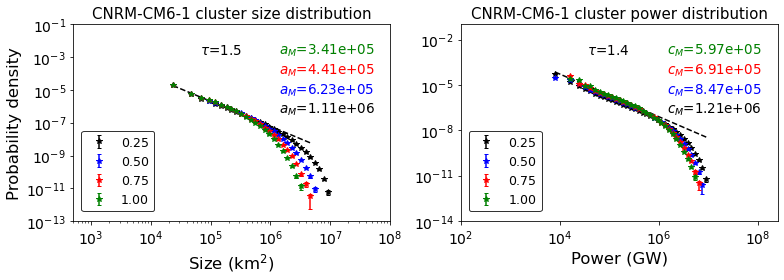

In [51]:
### set the plot specs:
### size
fig=plt.figure(figsize=(11,4.))
## grid: 1 row , 2 colum plot
gs = gridspec.GridSpec(1, 2)
## assign separate name for each axis
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

### first plot cluster size

plot_cluster_stats(ax1, pthresh_list, plot_params, hist_pcp_sizes, 
                       xvalue, diff, cluster_sizes)

### before we plot cluster power, change a few plot parameters

plot_params['istrt']=istrt_pow  ### start of the fit regime
plot_params['iend']=iend_pow    ### end of the fit regime
plot_params['fit_limit']=1e7    ## if extrapolating beyond the fit regime specify limit
plot_params['ytick_locator']=[1e-2, 1e-4, 1e-6, 1e-8, 1e-10,1e-12]
plot_params['xlim']=[1e2,2.5e8]
plot_params['ylim']=[1e-14,1e-1]


plot_params['TITLE']="%s cluster power distribution"%(TITLE)
plot_params['xlabel']="Power (GW)" 
plot_params['ylabel']="" 
plot_params['xm']="c_M" ## moment ratio

plot_cluster_stats(ax2, pthresh_list, plot_params, hist_pcp_clust_pow, 
                       pcp_clust_pow, pcp_clust_sz_diff, pcp_power)


plt.tight_layout()
plt.subplots_adjust(top=0.9)


SAVE_FIG=False
if SAVE_FIG:
    dirp='./' ## current location, but change as needed
    if forcing=='SSP':
        save_fig_name="./plots/"+"clusters_pdfs_SSP585_%s"%(model_list[model_index])+"_"+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+".pdf"
    elif forcing=='HIST':
        save_fig_name="./plots/"+"clusters_pdfs_%s"%(model_list[model_index])+"_"+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+".pdf"
    elif forcing=='obs':
        save_fig_name="./plots/"+"clusters_pdfs_%s"%('TRMM3B42')+"_"+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+".pdf"


    plt.savefig(save_fig_name,format='pdf',dpi=150,bbox_inches='tight')



### Log-linear ###

#### In the log-linear plot, the range over which we fit the exponential is different, so change the `istrt` and `iend` values 

In [52]:
### The x units are now linear, so must change these parameters ###
## set a ballpark range for the exponential fit for size and power ###
istrt_sz[0.25],iend_sz[0.25]=1e6,5.0e6 
istrt_sz[0.5],iend_sz[0.5]=1e6,5.0e6 
istrt_sz[0.75],iend_sz[0.75]=1e6,5.0e6 
istrt_sz[1.0],iend_sz[1.0]=.5e6,5.0e6 

istrt_pow[0.25],iend_pow[0.25]=2e6,6.0e6 
istrt_pow[0.5],iend_pow[0.5]=1.8e6,5.5e6
istrt_pow[0.75],iend_pow[0.75]=1.8e6,5.5e6 
istrt_pow[1.0],iend_pow[1.0]=1.8e6,5.5e6 

#### Modify other plot parameters ###

In [62]:
# istrt_pow,iend_pow=0.125e7,1.2e7 
plot_params['plot_type']='logylinearx'

## Fitting parameters ###
plot_params['nthresh']=10 ### threshold counts for bin to be valid
plot_params['istrt']=istrt_sz  ### start of the fit regime
plot_params['iend']=iend_sz    ### end of the fit regime
# plot_params['fit_limit']=fit_limit    ## if extrapolating beyond the fit regime specify limit
# plot_params['fit_operator']=fit_operator ## if extrapolating beyond the fit regime specify operator (greater or less)

### specify limits 
plot_params['xlim']=[5e2,0.5e7] 

### Change legend location ##
plot_params['leg_loc']=(.05, .575)
### Change the location where the moment ratios are printed ##
plot_params['posx']=[.5, .5, .5, 0.5, .35, .4, .4 ]

### Various labels
plot_params['TITLE']="%s cluster size distribution"%(TITLE)
plot_params['xlabel']="Size ($\mathrm{km^2}$)" 
plot_params['ylabel']="Probability density" 
plot_params['xm']="a_M" ## moment ratio
plot_params['xL']="a_L" ## moment ratio
plot_params['leg1_fontsize']=12.5

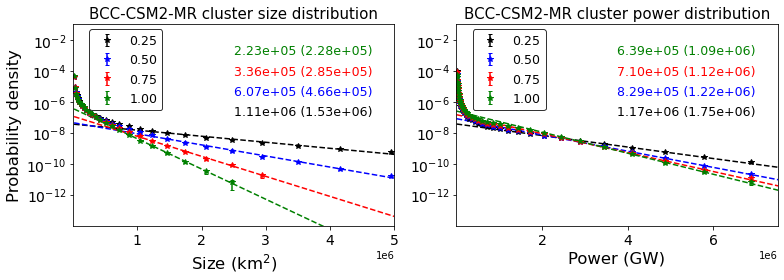

In [63]:
### set the plot specs:
### size
fig=plt.figure(figsize=(11,4.))
## grid: 1 row , 2 colum plot
gs = gridspec.GridSpec(1, 2)
## assign separate name for each axis
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

plot_cluster_stats(ax1, pthresh_list, plot_params, hist_pcp_sizes, 
                       xvalue, diff, cluster_sizes)

### change plot parameters for cluster power plot

plot_params['ytick_locator']=[1e-2, 1e-4, 1e-6, 1e-8, 1e-10,1e-12]
plot_params['xlim']=[1e2,0.75e7]
plot_params['ylim']=[1e-14,1e-1]
plot_params['istrt']=istrt_pow  ### start of the fit regime
plot_params['iend']=iend_pow    ### end of the fit regime


plot_params['TITLE']="%s cluster power distribution"%(TITLE)
plot_params['xlabel']="Power (GW)" 
plot_params['ylabel']="" 
plot_params['xm']="c_M" ## moment ratio

plot_cluster_stats(ax2, pthresh_list, plot_params, hist_pcp_clust_pow, 
                       pcp_clust_pow, pcp_clust_sz_diff, pcp_power)


plt.tight_layout()
plt.subplots_adjust(top=0.9)


SAVE_FIG=False
if SAVE_FIG:
    dirp='./' ## current location, but change as needed
    if forcing=='SSP':
        save_fig_name="./plots/"+"loglinear_clusters_pdfs_SSP585_%s"%(model_list[model_index])+"_"+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+".pdf"
    elif forcing=='HIST':
        save_fig_name="./plots/"+"loglinear_clusters_pdfs_%s"%(model_list[model_index])+"_"+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+".pdf"
    elif forcing=='obs':
        save_fig_name="./plots/"+"loglinear_clusters_pdfs_%s"%('TRMM3B42')+"_"+time_slice.start.strftime("%Y%m")+"_"+time_slice.stop.strftime("%Y%m")+".pdf"


    plt.savefig(save_fig_name,format='pdf',dpi=150,bbox_inches='tight')


